# CS 584 - SVM's and Ensemble Classifiers

Author: Asad Abdullah

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.utils import resample
from sklearn import svm

from sklearn.metrics import precision_recall_curve, auc, precision_recall_fscore_support

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import time
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import time

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

import pandas as pd
from sklearn.datasets import fetch_openml, load_breast_cancer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Dataset 1: Numeric-only (Breast Cancer):

*   Contains only numeric attributes, so minimal preprocessing is needed.

*   Standard scaling applied for SVMs and ensemble methods to prevent large-magnitude features from dominating.

In [20]:
# Dataset 1: Numeric-only (Breast Cancer)
data_bc = load_breast_cancer()
X_bc = pd.DataFrame(data_bc.data, columns=data_bc.feature_names)
y_bc = data_bc.target

# train / val / test split: 0.8 -> train, then 0.25 of that -> val
X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(
    X_bc, y_bc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bc
)
X_bc_train, X_bc_val, y_bc_train, y_bc_val = train_test_split(
    X_bc_train, y_bc_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_bc_train
)

print("Breast Cancer shapes:")
print("Train:", X_bc_train.shape, "Val:", X_bc_val.shape, "Test:", X_bc_test.shape)

# scaling for SVM
bc_preprocessor = Pipeline([
    ("scaler", StandardScaler())
])
X_bc_train_p = bc_preprocessor.fit_transform(X_bc_train)
X_bc_val_p   = bc_preprocessor.transform(X_bc_val)
X_bc_test_p  = bc_preprocessor.transform(X_bc_test)


Breast Cancer shapes:
Train: (341, 30) Val: (114, 30) Test: (114, 30)


Dataset 2: Mixed categorical + missing (Adult):


*   Contains both numeric and nominal categorical features with missing values (“?”).

*   Imputation strategy: median for numeric (robust to skew/outliers), most frequent for categorical.

*   Encoding: One-hot encoding for nominal features ensures SVM and tree-based models can handle categorical data numerically.

*   Scaling: StandardScaler applied to numeric features for SVM; tree-based ensemble models are insensitive to scaling but benefit from consistency across methods.


In [21]:
# Dataset 2: Adult Income (categorical + missing)
adult = fetch_openml("adult", version=2, as_frame=True)
df_adult = adult.frame.rename(columns={"class": "income"})

# target to 0/1
y_adult = np.where(df_adult["income"] == ">50K", 1, 0)
X_adult = df_adult.drop("income", axis=1)

# add artificial missing to numeric cols (5%)
rng = np.random.default_rng(RANDOM_STATE)
for col in X_adult.select_dtypes(include=["float64", "int64"]).columns[:2]:
    mask = rng.random(X_adult.shape[0]) < 0.05
    X_adult.loc[mask, col] = np.nan

num_cols = X_adult.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X_adult.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_adult = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# splits
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=RANDOM_STATE, stratify=y_adult
)
X_adult_train, X_adult_val, y_adult_train, y_adult_val = train_test_split(
    X_adult_train, y_adult_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_adult_train
)

adult_pipe = Pipeline([("preprocessor", preprocessor_adult)])
X_adult_train_p = adult_pipe.fit_transform(X_adult_train)
X_adult_val_p   = adult_pipe.transform(X_adult_val)
X_adult_test_p  = adult_pipe.transform(X_adult_test)

print("Adult Income processed shapes:")
print("Train:", X_adult_train_p.shape, "Val:", X_adult_val_p.shape, "Test:", X_adult_test_p.shape)


Adult Income processed shapes:
Train: (29304, 105) Val: (9769, 105) Test: (9769, 105)


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_full_metrics(y_true, y_pred, title="Metrics"):
    plt.close('all')
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary" if len(np.unique(y_true))==2 else "macro")

    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.show()


Class-imbalance check & strategies

In [23]:
print("\nClass distribution (Adult):", Counter(y_adult_train))
print("Class distribution (Breast Cancer):", Counter(y_bc_train))

adult_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_adult_train),
    y=y_adult_train
)
bc_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_bc_train),
    y=y_bc_train
)

print("Adult Income class weights:", dict(zip(np.unique(y_adult_train), adult_weights)))
print("Breast Cancer class weights:", dict(zip(np.unique(y_bc_train), bc_weights)))



Class distribution (Adult): Counter({np.int64(0): 22292, np.int64(1): 7012})
Class distribution (Breast Cancer): Counter({np.int64(1): 214, np.int64(0): 127})
Adult Income class weights: {np.int64(0): np.float64(0.6572761528799569), np.int64(1): np.float64(2.089560752994866)}
Breast Cancer class weights: {np.int64(0): np.float64(1.3425196850393701), np.int64(1): np.float64(0.7967289719626168)}


**Preprocessing Pipeline**

• Numeric Features: Median imputation → robust to outliers; then StandardScaler to center and normalize for SVM optimization stability.

• Categorical Features: Most-frequent imputation → preserves mode of distribution; One-Hot Encoding → suitable for nominal categories where order is meaningless.

• Ordinal Encoding would be used if any variable had inherent order (e.g., education levels), but in Adult most are nominal, so One-Hot Encoding is appropriate.



**Splitting Strategy**

80 % train, 20 % test, then 25 % of train → validation set.

Test data remain completely blind until the final evaluation.

For robust results, 5-fold Stratified CV will be used during model selection.

**Class Imbalance Handling**

The Adult dataset is imbalanced (~75 % ≤ 50K vs 25 % > 50K).
We will compare at least two remedies:

**Class-weighted SVM** (using class_weight="balanced")

Resampling via oversampling of the minority class (e.g., SMOTE).

**Trade-offs:**

class-weighting preserves all data but may underfit minority; oversampling increases recall but may risk overfitting duplicates.

Precision–recall and PR curves will be used to discuss the effect.

A1 – Synthetic Data & Visualization

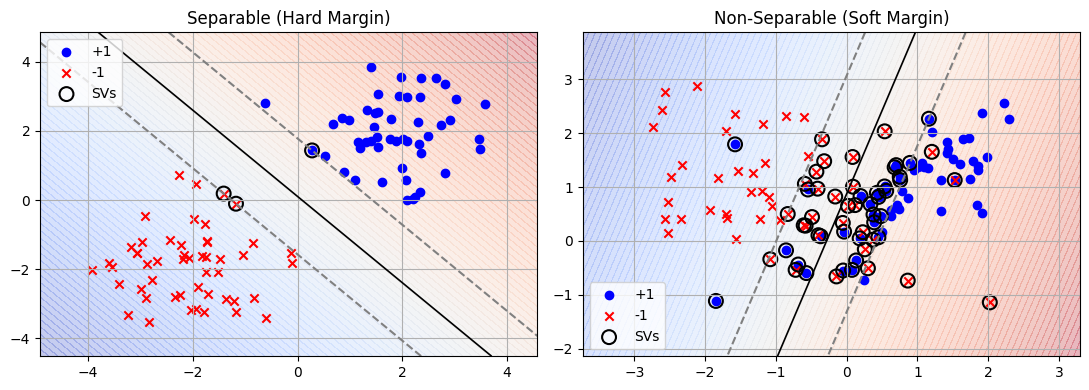

In [24]:
#Generate datasets
def make_separable(n_per_class=50):
    X_pos = np.random.randn(n_per_class, 2) + np.array([2, 2])
    X_neg = np.random.randn(n_per_class, 2) + np.array([-2, -2])
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(n_per_class), -np.ones(n_per_class)])
    return X, y

def make_nonseparable(n_samples=120, noise=0.8):
    X, y = datasets.make_classification(
        n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
        n_clusters_per_class=1, flip_y=0.1, class_sep=1.0, random_state=RANDOM_STATE
    )
    y = np.where(y == 1, 1, -1)
    X = X + noise * np.random.randn(*X.shape) * 0.1
    return X, y

X_sep, y_sep = make_separable()
X_nsep, y_nsep = make_nonseparable()

# Train SVMs
svm_sep = svm.SVC(kernel="linear", C=1e6)  # Hard margin
svm_sep.fit(X_sep, y_sep)

svm_nsep = svm.SVC(kernel="linear", C=1.0)  # Soft margin
svm_nsep.fit(X_nsep, y_nsep)

#  Plot function with decision regions, hyperplane, margins, SVs
def plot_svm(ax, model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    XX, YY = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)

    # Decision regions
    ax.contourf(XX, YY, Z, levels=np.linspace(Z.min(), Z.max(), 100),
                cmap=plt.cm.coolwarm, alpha=0.3)

    # Decision boundary and margins
    ax.contour(XX, YY, Z, levels=[0], colors='k', linewidths=1.2)
    ax.contour(XX, YY, Z, levels=[-1, 1], colors='grey', linestyles='--')

    # Points
    ax.scatter(X[y==1,0], X[y==1,1], c='b', marker='o', label='+1')
    ax.scatter(X[y==-1,0], X[y==-1,1], c='r', marker='x', label='-1')

    # Support vectors
    ax.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],
               s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='SVs')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
plot_svm(axes[0], svm_sep, X_sep, y_sep, "Separable (Hard Margin)")
plot_svm(axes[1], svm_nsep, X_nsep, y_nsep, "Non-Separable (Soft Margin)")
plt.tight_layout()
plt.show()

 A2 – Linear SVM (Hard Margin on Separable Data)

=== Hard-Margin Linear SVM (Separable Set) ===
Weights (w): [0.74378138 0.59657192]
Bias (b): -0.0624
Margin width: 2.0976
Number of support vectors: 3
Training Accuracy: 100.00%


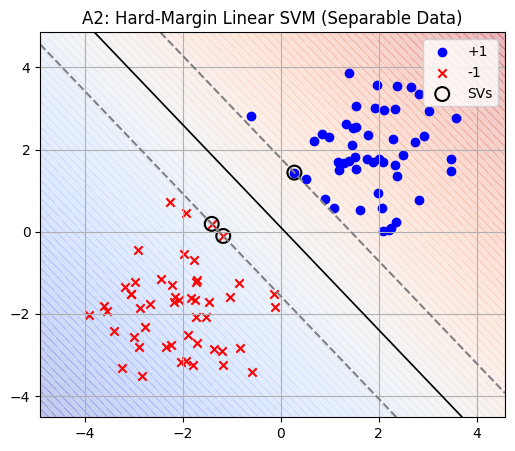


=== A2: Hard-Margin SVM Metrics ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Confusion Matrix:


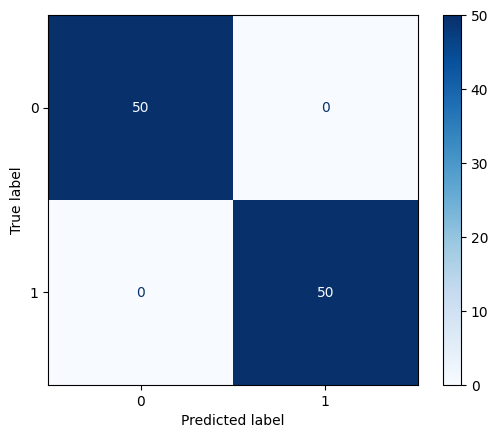

In [25]:
# Extract weights and bias
w_hard = svm_sep.coef_[0]
b_hard = svm_sep.intercept_[0]
margin = 2 / np.linalg.norm(w_hard)

print("=== Hard-Margin Linear SVM (Separable Set) ===")
print(f"Weights (w): {w_hard}")
print(f"Bias (b): {b_hard:.4f}")
print(f"Margin width: {margin:.4f}")
print(f"Number of support vectors: {len(svm_sep.support_)}")

# Verify correct classification
pred_sep = svm_sep.predict(X_sep)
accuracy_sep = np.mean(pred_sep == y_sep)
print(f"Training Accuracy: {accuracy_sep*100:.2f}%")

# Plot
fig, ax = plt.subplots(figsize=(6,5))
plot_svm(ax, svm_sep, X_sep, y_sep, "A2: Hard-Margin Linear SVM (Separable Data)")
plt.show()

y_pred_A2 = svm_sep.predict(X_sep)
print_full_metrics(y_sep, y_pred_A2, title="A2: Hard-Margin SVM Metrics")


A3 – Linear SVM (Soft Margin on Non-Separable Data)


=== Soft-Margin SVM (C=0.1) ===
Weights: [ 1.076 -0.353]  Bias: 0.471
Margin width: 1.765
Training Accuracy: 81.67%
Support Vectors: 68

=== A3 Soft-Margin (C=0.1) Metrics ===
Accuracy: 0.8167
Precision: 0.7703
Recall: 0.9194
F1 Score: 0.8382

Confusion Matrix:


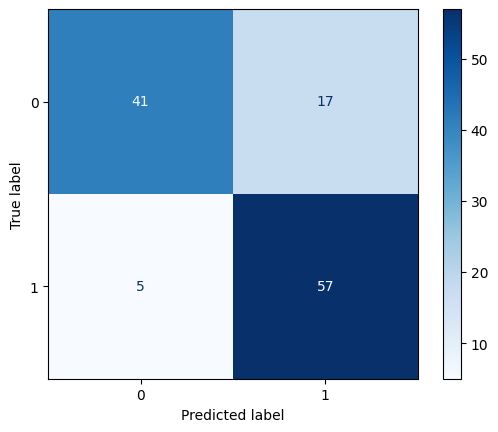


=== Soft-Margin SVM (C=1) ===
Weights: [ 1.408 -0.456]  Bias: 0.399
Margin width: 1.351
Training Accuracy: 82.50%
Support Vectors: 56

=== A3 Soft-Margin (C=1) Metrics ===
Accuracy: 0.8250
Precision: 0.7971
Recall: 0.8871
F1 Score: 0.8397

Confusion Matrix:


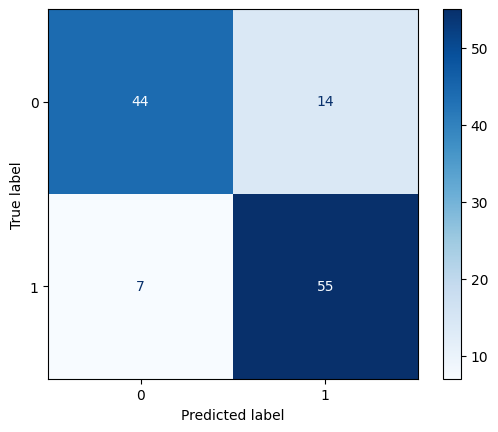


=== Soft-Margin SVM (C=10) ===
Weights: [ 1.444 -0.474]  Bias: 0.395
Margin width: 1.316
Training Accuracy: 82.50%
Support Vectors: 54

=== A3 Soft-Margin (C=10) Metrics ===
Accuracy: 0.8250
Precision: 0.7971
Recall: 0.8871
F1 Score: 0.8397

Confusion Matrix:


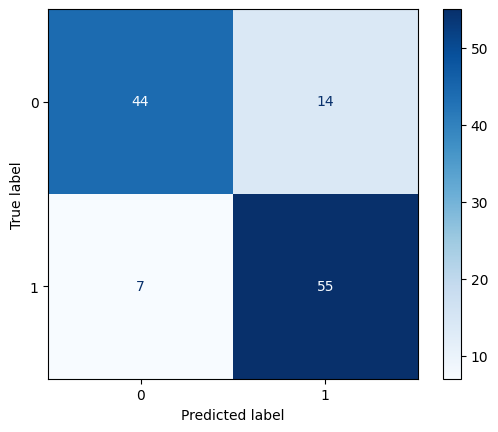

<Figure size 640x480 with 0 Axes>

In [26]:
Cs = [0.1, 1, 10]
fig, axes = plt.subplots(1, len(Cs), figsize=(15, 4))

for i, C in enumerate(Cs):
    svm_soft = svm.SVC(kernel="linear", C=C)
    svm_soft.fit(X_nsep, y_nsep)

    w_soft = svm_soft.coef_[0]
    b_soft = svm_soft.intercept_[0]
    margin = 2 / np.linalg.norm(w_soft)
    acc = svm_soft.score(X_nsep, y_nsep)

    print(f"\n=== Soft-Margin SVM (C={C}) ===")
    print(f"Weights: {np.round(w_soft, 3)}  Bias: {b_soft:.3f}")
    print(f"Margin width: {margin:.3f}")
    print(f"Training Accuracy: {acc*100:.2f}%")
    print(f"Support Vectors: {len(svm_soft.support_)}")

    y_pred_soft = svm_soft.predict(X_nsep)
    print_full_metrics(y_nsep, y_pred_soft, title=f"A3 Soft-Margin (C={C}) Metrics")


    plot_svm(axes[i], svm_soft, X_nsep, y_nsep, f"C={C}")

plt.suptitle("A3: Soft-Margin Linear SVM on Non-Separable Data", y=1.03)
plt.tight_layout()
plt.show()

The soft-margin SVM introduces a penalty 𝐶 to control the trade-off between maximizing margin width and minimizing classification errors.

*   Low C (0.1): Large margin, allows more misclassifications → underfitting.


*   Moderate C (1): Balanced trade-off between margin and errors.


*   High C (10): Very strict, smaller margin, fewer training errors → potential overfitting.





The number of support vectors typically increases for smaller 𝐶, since more points influence the decision boundary.


**A2	Separable**: 	Hard-margin, Parameter	C → ∞,	Perfect separation, max margin

**A3	Non-separable**: 	Soft-margin, Parameter	C ∈ {0.1, 1, 10},	Trade-off between margin width and misclassification

A4 – Kernel SVM (Polynomial and RBF)

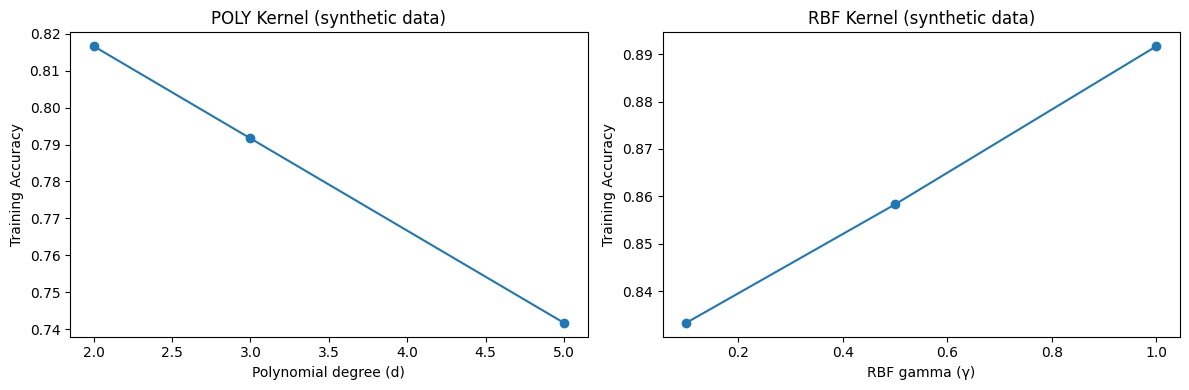

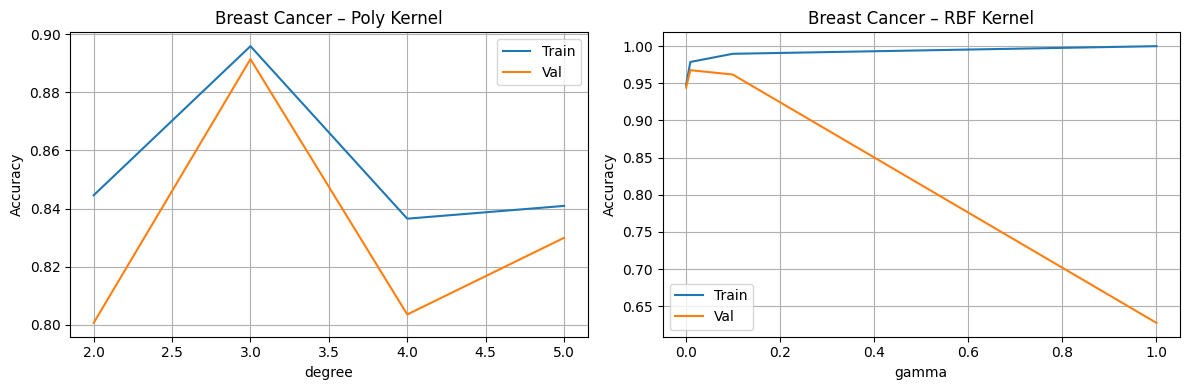


=== A4 Breast Cancer – Polynomial Kernel ===
Accuracy: 0.9035
Precision: 0.8675
Recall: 1.0000
F1 Score: 0.9290

Confusion Matrix:


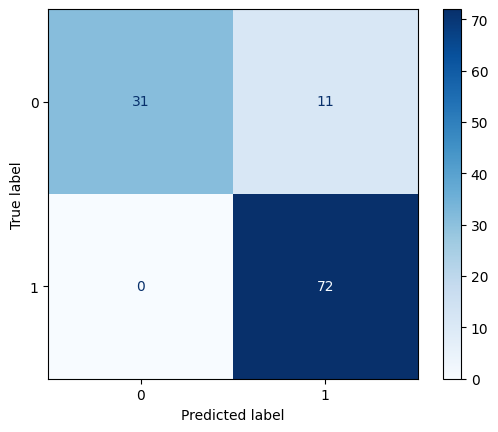


=== A4 Breast Cancer – RBF Kernel ===
Accuracy: 0.9649
Precision: 0.9595
Recall: 0.9861
F1 Score: 0.9726

Confusion Matrix:


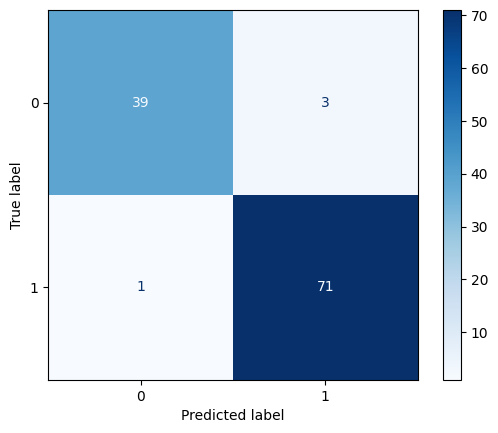

In [27]:
# synthetic data experiments
kernels = [("poly", {"degree": [2, 3, 5]}), ("rbf", {"gamma": [0.1, 0.5, 1]})]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (kernel, params) in enumerate(kernels):
    if kernel == "poly":
        scores = []
        for d in params["degree"]:
            clf = svm.SVC(kernel="poly", degree=d, C=1.0)
            clf.fit(X_nsep, y_nsep)
            scores.append(clf.score(X_nsep, y_nsep))
        axes[i].plot(params["degree"], scores, marker="o")
        axes[i].set_xlabel("Polynomial degree (d)")
    else:
        scores = []
        for g in params["gamma"]:
            clf = svm.SVC(kernel="rbf", gamma=g, C=1.0)
            clf.fit(X_nsep, y_nsep)
            scores.append(clf.score(X_nsep, y_nsep))
        axes[i].plot(params["gamma"], scores, marker="o")
        axes[i].set_xlabel("RBF gamma (γ)")
    axes[i].set_ylabel("Training Accuracy")
    axes[i].set_title(f"{kernel.upper()} Kernel (synthetic data)")
plt.tight_layout()
plt.show()

# Validation curves on real datasets (Breast & Adult)
def plot_validation_curve(X_train, y_train, kernel, param_name, param_range, title):
    train_scores, val_scores = validation_curve(
        svm.SVC(kernel=kernel),
        X_train, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=5, scoring="accuracy"
    )
    plt.plot(param_range, np.mean(train_scores, axis=1), label="Train")
    plt.plot(param_range, np.mean(val_scores, axis=1), label="Val")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(axes[0])
plot_validation_curve(X_bc_train_p, y_bc_train, "poly", "degree", [2, 3, 4, 5], "Breast Cancer – Poly Kernel")
plt.sca(axes[1])
plot_validation_curve(X_bc_train_p, y_bc_train, "rbf", "gamma", [0.001, 0.01, 0.1, 1], "Breast Cancer – RBF Kernel")
plt.tight_layout()
plt.show()

clf_poly = svm.SVC(kernel="poly", degree=3, C=1.0)
clf_poly.fit(X_bc_train_p, y_bc_train)
y_pred_poly = clf_poly.predict(X_bc_test_p)
print_full_metrics(y_bc_test, y_pred_poly, title="A4 Breast Cancer – Polynomial Kernel")

clf_rbf = svm.SVC(kernel="rbf", gamma=0.01, C=1.0)
clf_rbf.fit(X_bc_train_p, y_bc_train)
y_pred_rbf = clf_rbf.predict(X_bc_test_p)
print_full_metrics(y_bc_test, y_pred_rbf, title="A4 Breast Cancer – RBF Kernel")


A5 – One-vs-Rest Multi-Class SVM


=== A5: Multi-class SVM (Digits Dataset) ===
Accuracy: 0.9888888888888889
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        54
           1      0.948     1.000     0.973        55
           2      1.000     1.000     1.000        53
           3      1.000     1.000     1.000        55
           4      1.000     1.000     1.000        54
           5      1.000     0.982     0.991        55
           6      1.000     0.981     0.991        54
           7      0.982     1.000     0.991        54
           8      0.980     0.942     0.961        52
           9      0.981     0.981     0.981        54

    accuracy                          0.989       540
   macro avg      0.989     0.989     0.989       540
weighted avg      0.989     0.989     0.989       540


=== A5 Multi-Class SVM Metrics ===
Accuracy: 0.9889
Precision: 0.9892
Recall: 0.9887
F1 Score: 0.9888

Confusion Matrix:


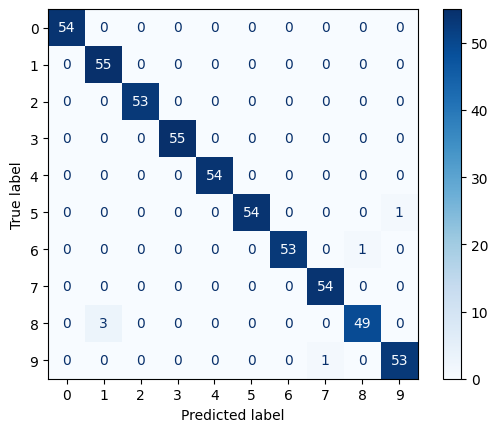

In [28]:
digits = load_digits()
X_dig = digits.data
y_dig = digits.target

X_tr, X_te, y_tr, y_te = train_test_split(
    X_dig, y_dig, test_size=0.3, random_state=RANDOM_STATE, stratify=y_dig
)

# OvR is the default strategy of sklearn’s SVC
multi_svm = svm.SVC(kernel="rbf", gamma=0.001, C=5)
multi_svm.fit(X_tr, y_tr)
y_pred = multi_svm.predict(X_te)

print("\n=== A5: Multi-class SVM (Digits Dataset) ===")
print("Accuracy:", accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, digits=3))

print_full_metrics(y_te, y_pred, title="A5 Multi-Class SVM Metrics")


A6 – Class Imbalance Experiment

Skewed ratio: Counter({np.int64(0): 22292, np.int64(1): 7012})


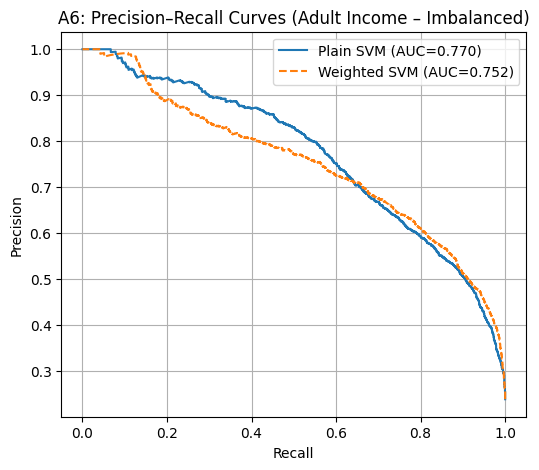

Plain SVM    → Precision: 0.770, Recall: 0.580, F1: 0.662, AUC(PR): 0.770
Weighted SVM → Precision: 0.556, Recall: 0.869, F1: 0.678, AUC(PR): 0.752

=== A6 Plain SVM – Test Metrics ===
Accuracy: 0.8581
Precision: 0.7701
Recall: 0.5804
F1 Score: 0.6620

Confusion Matrix:


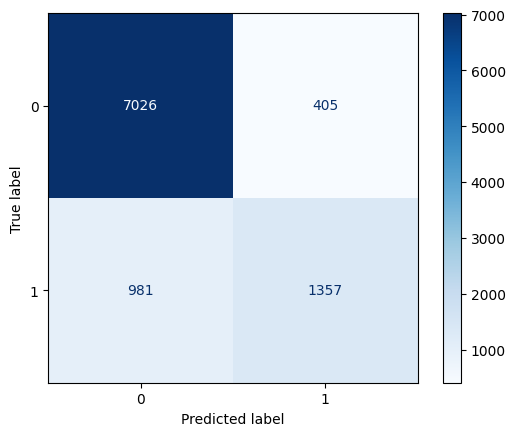


=== A6 Weighted SVM – Test Metrics ===
Accuracy: 0.8025
Precision: 0.5560
Recall: 0.8691
F1 Score: 0.6781

Confusion Matrix:


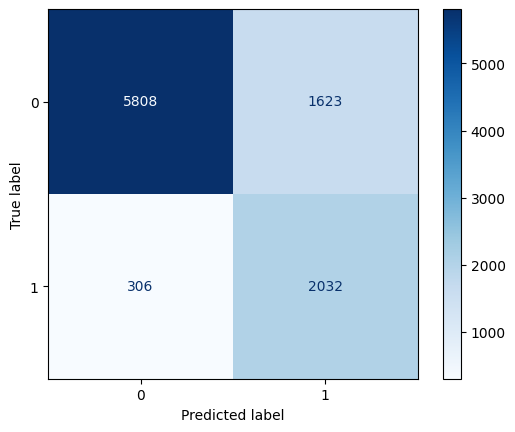

In [29]:
minor_idx = np.where(y_adult_train == 1)[0]
major_idx = np.where(y_adult_train == 0)[0]

np.random.seed(RANDOM_STATE)
desired_size = min(len(major_idx), len(minor_idx) * 5)
major_sample = np.random.choice(major_idx, size=desired_size, replace=False)

X_skew = np.vstack((
    X_adult_train_p[major_sample].toarray(),
    X_adult_train_p[minor_idx].toarray()
))
y_skew = np.hstack((
    y_adult_train[major_sample],
    y_adult_train[minor_idx]
))

print("Skewed ratio:", Counter(y_skew))

# Plain SVM
plain = svm.SVC(kernel="rbf", gamma=0.05, C=1.0, probability=True, random_state=RANDOM_STATE)
plain.fit(X_skew, y_skew)
probs_plain = plain.predict_proba(X_adult_test_p.toarray())[:, 1]

prec1, rec1, _ = precision_recall_curve(y_adult_test, probs_plain)
auc_plain = auc(rec1, prec1)

#  Weighted SVM
weighted = svm.SVC(kernel="rbf", gamma=0.05, C=1.0, class_weight="balanced",
                   probability=True, random_state=RANDOM_STATE)
weighted.fit(X_skew, y_skew)
probs_weighted = weighted.predict_proba(X_adult_test_p.toarray())[:, 1]

prec2, rec2, _ = precision_recall_curve(y_adult_test, probs_weighted)
auc_weighted = auc(rec2, prec2)

# Plot PR curves
plt.figure(figsize=(6, 5))
plt.plot(rec1, prec1, label=f"Plain SVM (AUC={auc_plain:.3f})")
plt.plot(rec2, prec2, label=f"Weighted SVM (AUC={auc_weighted:.3f})", linestyle="--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("A6: Precision–Recall Curves (Adult Income – Imbalanced)")
plt.legend()
plt.grid(True)
plt.show()

#  Performance summary
pred_plain = plain.predict(X_adult_test_p.toarray())
pred_weighted = weighted.predict(X_adult_test_p.toarray())

prec_p, rec_p, f1_p, _ = precision_recall_fscore_support(y_adult_test, pred_plain, average="binary")
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_adult_test, pred_weighted, average="binary")

print(f"Plain SVM    → Precision: {prec_p:.3f}, Recall: {rec_p:.3f}, F1: {f1_p:.3f}, AUC(PR): {auc_plain:.3f}")
print(f"Weighted SVM → Precision: {prec_w:.3f}, Recall: {rec_w:.3f}, F1: {f1_w:.3f}, AUC(PR): {auc_weighted:.3f}")

print_full_metrics(y_adult_test, pred_plain, title="A6 Plain SVM – Test Metrics")
print_full_metrics(y_adult_test, pred_weighted, title="A6 Weighted SVM – Test Metrics")



Part B - Ensemble Classifiers

Part B1 – Bagging vs Random Forest


Bagging (n_estimators=10)
Training time: 2.37s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.909     0.952     0.930        42
           1      0.971     0.944     0.958        72

    accuracy                          0.947       114
   macro avg      0.940     0.948     0.944       114
weighted avg      0.948     0.947     0.948       114

OOB Score ≈ 0.947

=== B1 Bagging (n=10) Metrics ===
Accuracy: 0.9474
Precision: 0.9714
Recall: 0.9444
F1 Score: 0.9577

Confusion Matrix:


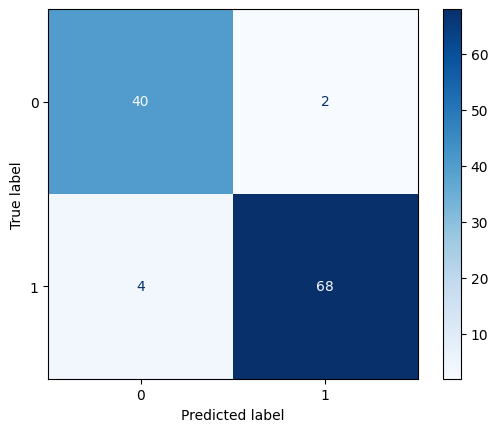


Bagging (n_estimators=50)
Training time: 0.19s | Test Accuracy: 93.86%
              precision    recall  f1-score   support

           0      0.907     0.929     0.918        42
           1      0.958     0.944     0.951        72

    accuracy                          0.939       114
   macro avg      0.932     0.937     0.934       114
weighted avg      0.939     0.939     0.939       114

OOB Score ≈ 0.947

=== B1 Bagging (n=50) Metrics ===
Accuracy: 0.9386
Precision: 0.9577
Recall: 0.9444
F1 Score: 0.9510

Confusion Matrix:


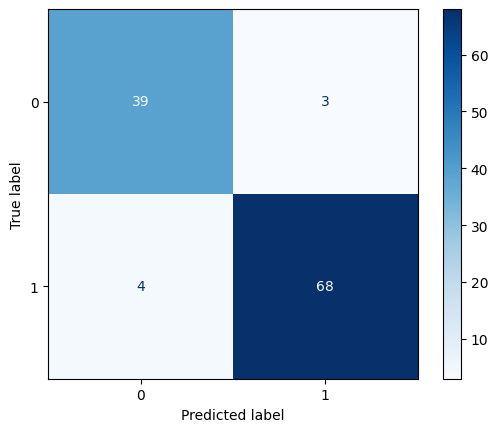


Bagging (n_estimators=100)
Training time: 0.35s | Test Accuracy: 93.86%
              precision    recall  f1-score   support

           0      0.907     0.929     0.918        42
           1      0.958     0.944     0.951        72

    accuracy                          0.939       114
   macro avg      0.932     0.937     0.934       114
weighted avg      0.939     0.939     0.939       114

OOB Score ≈ 0.947

=== B1 Bagging (n=100) Metrics ===
Accuracy: 0.9386
Precision: 0.9577
Recall: 0.9444
F1 Score: 0.9510

Confusion Matrix:


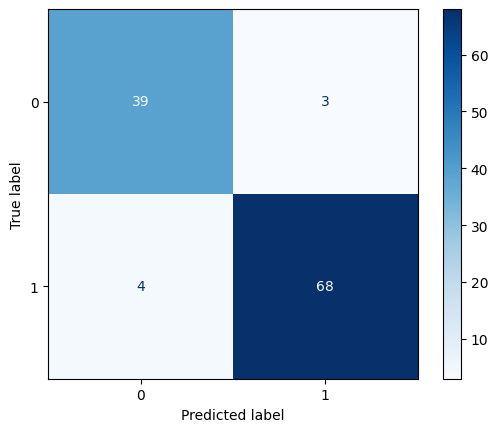


Bagging (n_estimators=200)
Training time: 0.77s | Test Accuracy: 93.86%
              precision    recall  f1-score   support

           0      0.907     0.929     0.918        42
           1      0.958     0.944     0.951        72

    accuracy                          0.939       114
   macro avg      0.932     0.937     0.934       114
weighted avg      0.939     0.939     0.939       114

OOB Score ≈ 0.953

=== B1 Bagging (n=200) Metrics ===
Accuracy: 0.9386
Precision: 0.9577
Recall: 0.9444
F1 Score: 0.9510

Confusion Matrix:


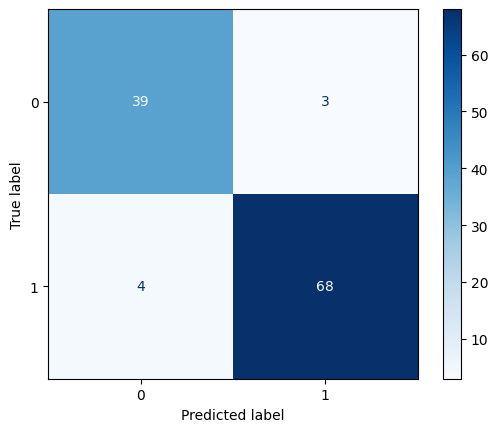


Random Forest (n_estimators=10)
Training time: 0.03s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.909     0.952     0.930        42
           1      0.971     0.944     0.958        72

    accuracy                          0.947       114
   macro avg      0.940     0.948     0.944       114
weighted avg      0.948     0.947     0.948       114

OOB Score ≈ 0.930

=== B1 Random Forest (n=10) Metrics ===
Accuracy: 0.9474
Precision: 0.9714
Recall: 0.9444
F1 Score: 0.9577

Confusion Matrix:


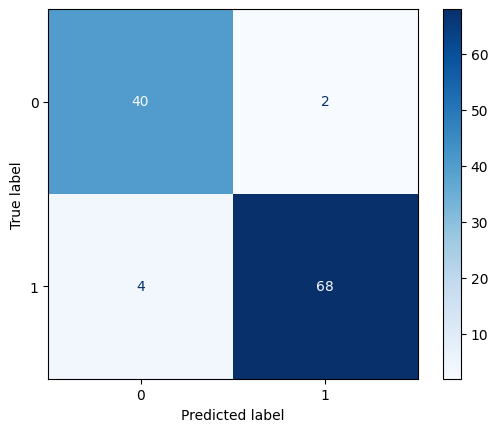


Random Forest (n_estimators=50)
Training time: 0.10s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114

OOB Score ≈ 0.950

=== B1 Random Forest (n=50) Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


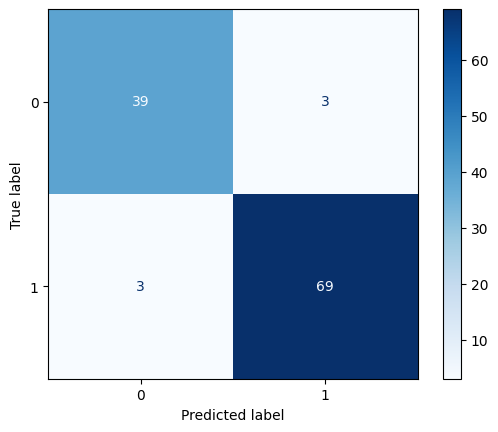


Random Forest (n_estimators=100)
Training time: 0.20s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114

OOB Score ≈ 0.962

=== B1 Random Forest (n=100) Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


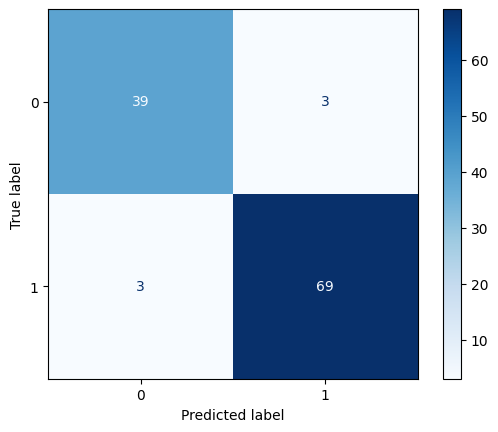


Random Forest (n_estimators=200)
Training time: 0.39s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114

OOB Score ≈ 0.956

=== B1 Random Forest (n=200) Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


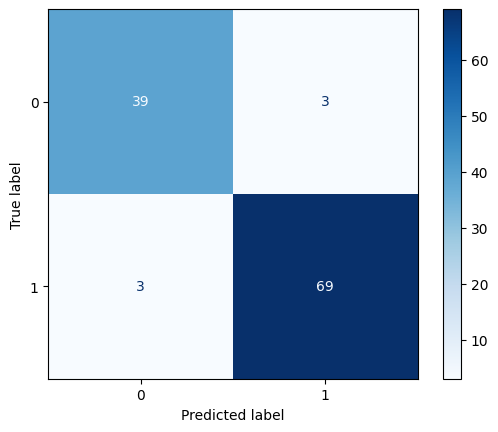

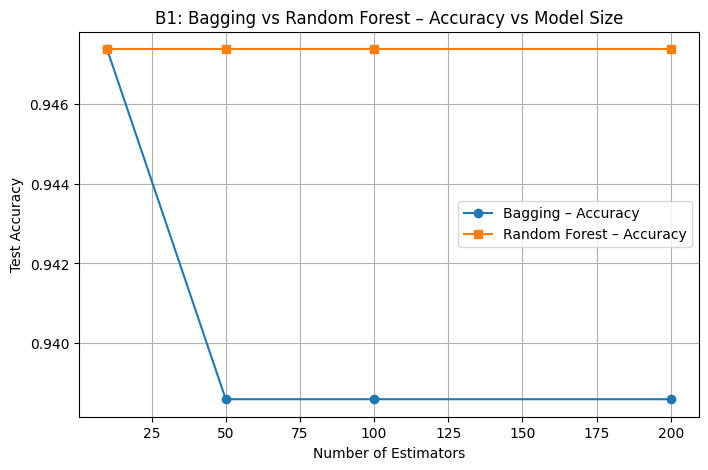

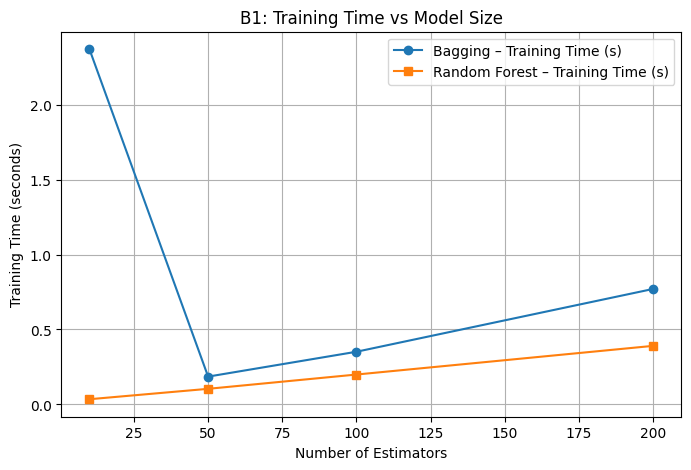

In [30]:

X_train, X_test, y_train, y_test = X_bc_train_p, X_bc_test_p, y_bc_train, y_bc_test

# Helper function
def train_and_evaluate(model, name):
    """Train model, record time, print performance."""
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name}")
    print(f"Training time: {train_time:.2f}s | Test Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred, digits=3))
    return acc, train_time


#  Bagging (Decision Tree base)
bag_acc, bag_time, bag_oob = [], [], []
n_estimators_list = [10, 50, 100, 200]

for n in n_estimators_list:
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        n_estimators=n,
        oob_score=True,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    acc, t = train_and_evaluate(bag, f"Bagging (n_estimators={n})")
    bag_acc.append(acc)
    bag_time.append(t)
    bag_oob.append(bag.oob_score_)
    print(f"OOB Score ≈ {bag.oob_score_:.3f}")

    y_pred = bag.predict(X_test)
    print_full_metrics(y_test, y_pred, title=f"B1 Bagging (n={n}) Metrics")



#  Random Forest
rf_acc, rf_time, rf_oob = [], [], []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        max_features="sqrt",   # key difference vs Bagging
        oob_score=True,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    acc, t = train_and_evaluate(rf, f"Random Forest (n_estimators={n})")
    rf_acc.append(acc)
    rf_time.append(t)
    rf_oob.append(rf.oob_score_)
    print(f"OOB Score ≈ {rf.oob_score_:.3f}")

    y_pred = rf.predict(X_test)
    print_full_metrics(y_test, y_pred, title=f"B1 Random Forest (n={n}) Metrics")


# Plot Comparison
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, bag_acc, marker="o", label="Bagging – Accuracy")
plt.plot(n_estimators_list, rf_acc, marker="s", label="Random Forest – Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracy")
plt.title("B1: Bagging vs Random Forest – Accuracy vs Model Size")
plt.legend(); plt.grid(True)
plt.show()
print("\n")
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, bag_time, marker="o", label="Bagging – Training Time (s)")
plt.plot(n_estimators_list, rf_time, marker="s", label="Random Forest – Training Time (s)")
plt.xlabel("Number of Estimators")
plt.ylabel("Training Time (seconds)")
plt.title("B1: Training Time vs Model Size")
plt.legend(); plt.grid(True)
plt.show()

B2 – AdaBoost & Gradient Boosting / XGBoost


AdaBoost (lr=0.01, n=50)
Training time: 0.14s | Test Accuracy: 93.86%
              precision    recall  f1-score   support

           0      0.907     0.929     0.918        42
           1      0.958     0.944     0.951        72

    accuracy                          0.939       114
   macro avg      0.932     0.937     0.934       114
weighted avg      0.939     0.939     0.939       114


=== B2 AdaBoost (lr=0.01, n=50) Metrics ===
Accuracy: 0.9386
Precision: 0.9577
Recall: 0.9444
F1 Score: 0.9510

Confusion Matrix:


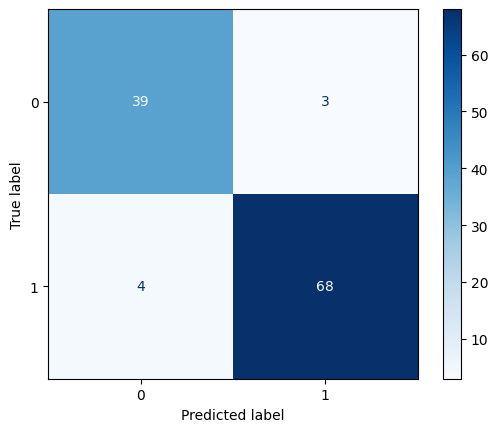


AdaBoost (lr=0.01, n=100)
Training time: 0.27s | Test Accuracy: 93.86%
              precision    recall  f1-score   support

           0      0.907     0.929     0.918        42
           1      0.958     0.944     0.951        72

    accuracy                          0.939       114
   macro avg      0.932     0.937     0.934       114
weighted avg      0.939     0.939     0.939       114


=== B2 AdaBoost (lr=0.01, n=100) Metrics ===
Accuracy: 0.9386
Precision: 0.9577
Recall: 0.9444
F1 Score: 0.9510

Confusion Matrix:


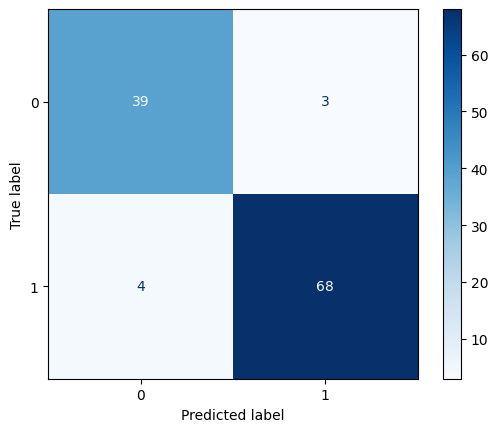


AdaBoost (lr=0.01, n=200)
Training time: 0.53s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 AdaBoost (lr=0.01, n=200) Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


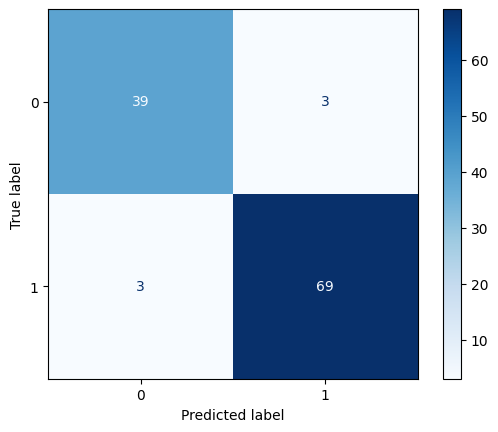


AdaBoost (lr=0.1, n=50)
Training time: 0.15s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 AdaBoost (lr=0.1, n=50) Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


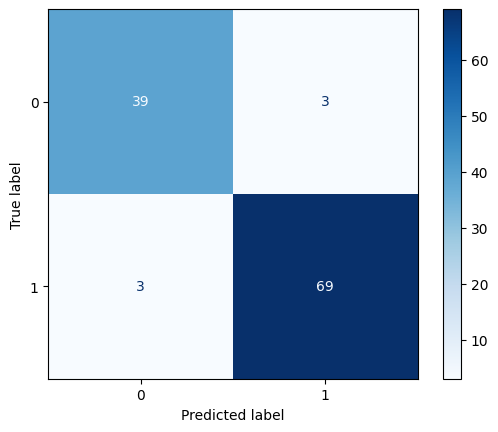


AdaBoost (lr=0.1, n=100)
Training time: 0.27s | Test Accuracy: 93.86%
              precision    recall  f1-score   support

           0      0.907     0.929     0.918        42
           1      0.958     0.944     0.951        72

    accuracy                          0.939       114
   macro avg      0.932     0.937     0.934       114
weighted avg      0.939     0.939     0.939       114


=== B2 AdaBoost (lr=0.1, n=100) Metrics ===
Accuracy: 0.9386
Precision: 0.9577
Recall: 0.9444
F1 Score: 0.9510

Confusion Matrix:


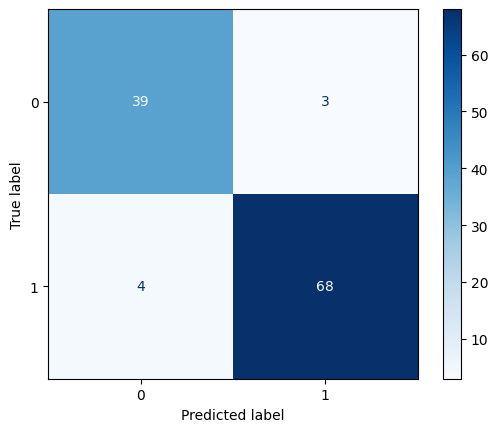


AdaBoost (lr=0.1, n=200)
Training time: 0.53s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 AdaBoost (lr=0.1, n=200) Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


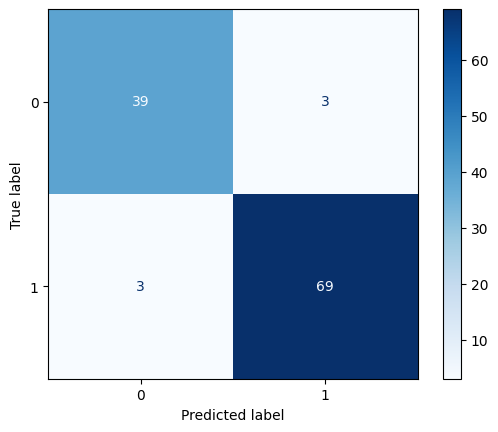


AdaBoost (lr=1.0, n=50)
Training time: 0.13s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.950     0.905     0.927        42
           1      0.946     0.972     0.959        72

    accuracy                          0.947       114
   macro avg      0.948     0.938     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 AdaBoost (lr=1.0, n=50) Metrics ===
Accuracy: 0.9474
Precision: 0.9459
Recall: 0.9722
F1 Score: 0.9589

Confusion Matrix:


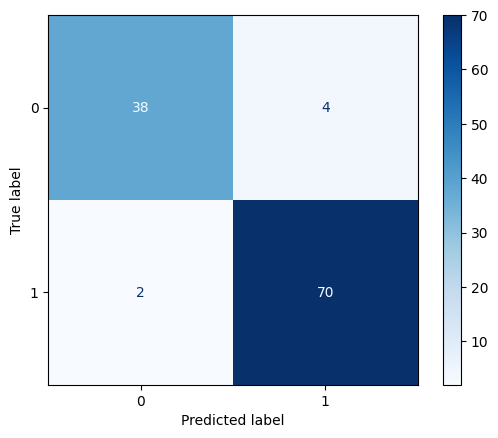


AdaBoost (lr=1.0, n=100)
Training time: 0.26s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.950     0.905     0.927        42
           1      0.946     0.972     0.959        72

    accuracy                          0.947       114
   macro avg      0.948     0.938     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 AdaBoost (lr=1.0, n=100) Metrics ===
Accuracy: 0.9474
Precision: 0.9459
Recall: 0.9722
F1 Score: 0.9589

Confusion Matrix:


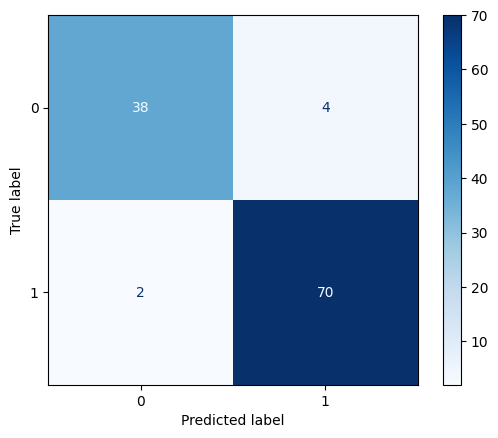


AdaBoost (lr=1.0, n=200)
Training time: 0.54s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.950     0.905     0.927        42
           1      0.946     0.972     0.959        72

    accuracy                          0.947       114
   macro avg      0.948     0.938     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 AdaBoost (lr=1.0, n=200) Metrics ===
Accuracy: 0.9474
Precision: 0.9459
Recall: 0.9722
F1 Score: 0.9589

Confusion Matrix:


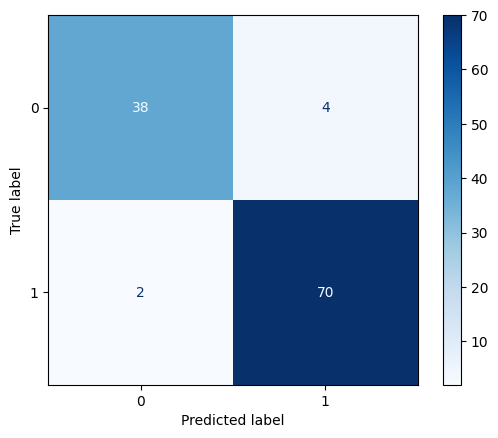

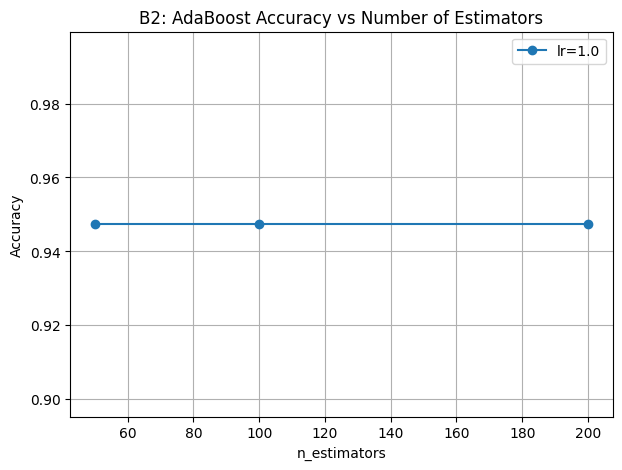


GradientBoosting (depth=1)
Training time: 0.17s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.950     0.905     0.927        42
           1      0.946     0.972     0.959        72

    accuracy                          0.947       114
   macro avg      0.948     0.938     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 GradientBoosting (depth=1) Metrics ===
Accuracy: 0.9474
Precision: 0.9459
Recall: 0.9722
F1 Score: 0.9589

Confusion Matrix:


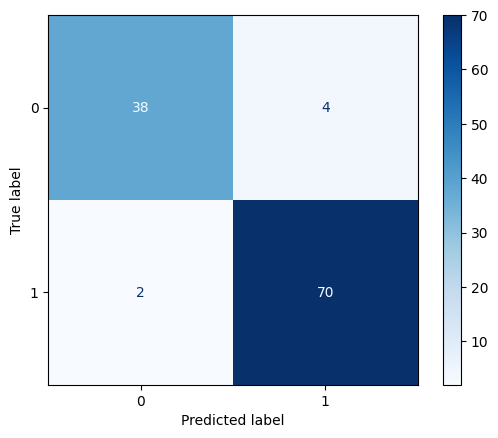


GradientBoosting (depth=3)
Training time: 0.35s | Test Accuracy: 93.86%
              precision    recall  f1-score   support

           0      0.927     0.905     0.916        42
           1      0.945     0.958     0.952        72

    accuracy                          0.939       114
   macro avg      0.936     0.932     0.934       114
weighted avg      0.938     0.939     0.938       114


=== B2 GradientBoosting (depth=3) Metrics ===
Accuracy: 0.9386
Precision: 0.9452
Recall: 0.9583
F1 Score: 0.9517

Confusion Matrix:


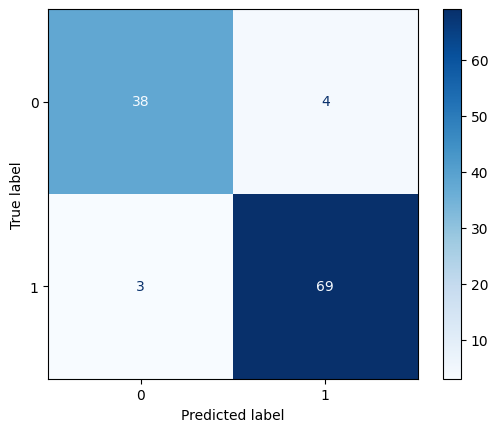


GradientBoosting (depth=5)
Training time: 0.56s | Test Accuracy: 92.98%
              precision    recall  f1-score   support

           0      0.905     0.905     0.905        42
           1      0.944     0.944     0.944        72

    accuracy                          0.930       114
   macro avg      0.925     0.925     0.925       114
weighted avg      0.930     0.930     0.930       114


=== B2 GradientBoosting (depth=5) Metrics ===
Accuracy: 0.9298
Precision: 0.9444
Recall: 0.9444
F1 Score: 0.9444

Confusion Matrix:


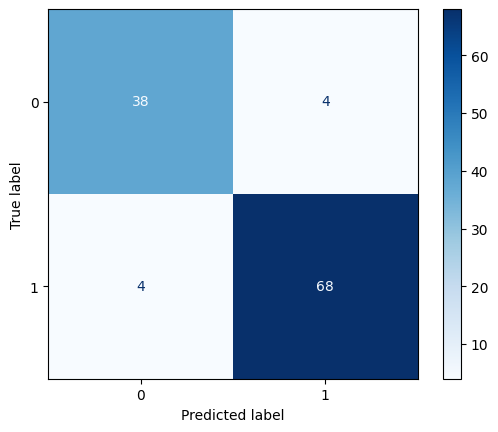

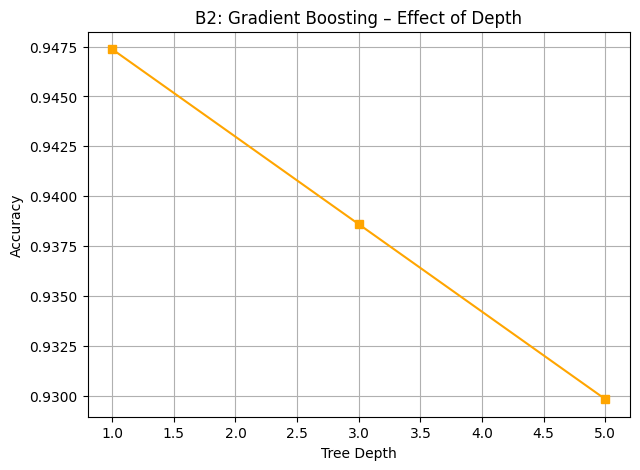

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (lr=0.01)
Training time: 0.40s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114


=== B2 XGBoost (lr=0.01) Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


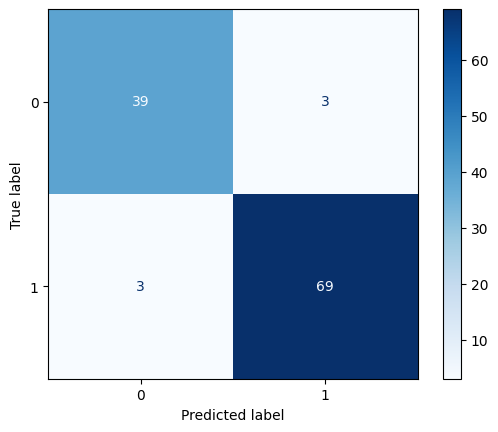

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (lr=0.1)
Training time: 0.20s | Test Accuracy: 92.98%
              precision    recall  f1-score   support

           0      0.905     0.905     0.905        42
           1      0.944     0.944     0.944        72

    accuracy                          0.930       114
   macro avg      0.925     0.925     0.925       114
weighted avg      0.930     0.930     0.930       114


=== B2 XGBoost (lr=0.1) Metrics ===
Accuracy: 0.9298
Precision: 0.9444
Recall: 0.9444
F1 Score: 0.9444

Confusion Matrix:


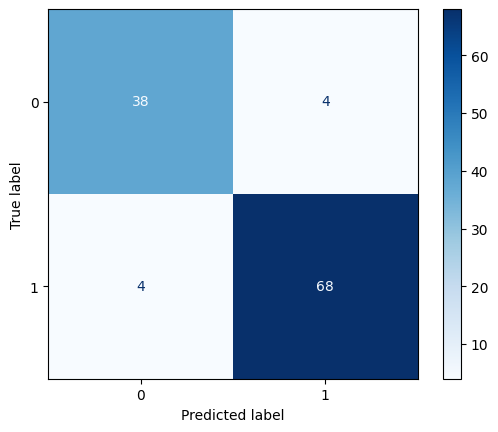

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:20:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (lr=0.3)
Training time: 0.12s | Test Accuracy: 95.61%
              precision    recall  f1-score   support

           0      0.974     0.905     0.938        42
           1      0.947     0.986     0.966        72

    accuracy                          0.956       114
   macro avg      0.961     0.945     0.952       114
weighted avg      0.957     0.956     0.956       114


=== B2 XGBoost (lr=0.3) Metrics ===
Accuracy: 0.9561
Precision: 0.9467
Recall: 0.9861
F1 Score: 0.9660

Confusion Matrix:


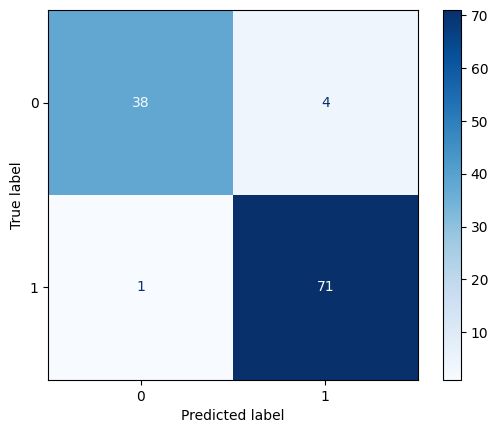

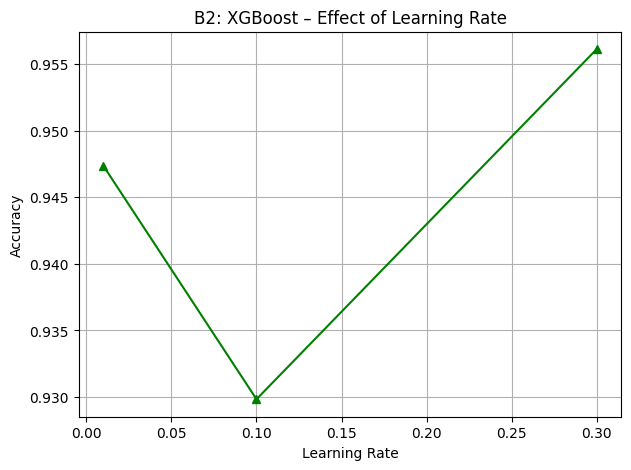

In [31]:
X_train, X_test, y_train, y_test = X_bc_train_p, X_bc_test_p, y_bc_train, y_bc_test

def train_boost(model, name):
    start = time.time()
    model.fit(X_train, y_train)
    dur = time.time() - start
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name}")
    print(f"Training time: {dur:.2f}s | Test Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred, digits=3))
    return acc, dur

#  AdaBoost – Decision Stumps (depth=1)
ada_acc, ada_time = [], []
n_estimators = [50, 100, 200]
learning_rates = [0.01, 0.1, 1.0]

for lr in learning_rates:
    for n in n_estimators:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
            n_estimators=n,
            learning_rate=lr,
            random_state=RANDOM_STATE
        )
        acc, dur = train_boost(ada, f"AdaBoost (lr={lr}, n={n})")
        ada_acc.append(acc)
        ada_time.append(dur)

        y_pred_ada = ada.predict(X_test)
        print_full_metrics(y_test, y_pred_ada, title=f"B2 AdaBoost (lr={lr}, n={n}) Metrics")


plt.figure(figsize=(7,5))
plt.plot(n_estimators, ada_acc[-3:], marker="o", label=f"lr={lr}")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("B2: AdaBoost Accuracy vs Number of Estimators")
plt.legend(); plt.grid(True); plt.show()

#  Gradient Boosting (sklearn)
gb_acc, gb_time = [], []
depths = [1, 3, 5]

for d in depths:
    gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=d,
        subsample=0.8,
        random_state=RANDOM_STATE
    )
    acc, dur = train_boost(gb, f"GradientBoosting (depth={d})")
    gb_acc.append(acc)
    gb_time.append(dur)

    y_pred_gb = gb.predict(X_test)
    print_full_metrics(y_test, y_pred_gb, title=f"B2 GradientBoosting (depth={d}) Metrics")


plt.figure(figsize=(7,5))
plt.plot(depths, gb_acc, marker="s", color="orange")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("B2: Gradient Boosting – Effect of Depth")
plt.grid(True); plt.show()

#  XGBoost
xgb_acc, xgb_time = [], []
lrs = [0.01, 0.1, 0.3]

for lr in lrs:
    xgb = XGBClassifier(
        n_estimators=200,
        learning_rate=lr,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    acc, dur = train_boost(xgb, f"XGBoost (lr={lr})")
    xgb_acc.append(acc)
    xgb_time.append(dur)

    y_pred_xgb = xgb.predict(X_test)
    print_full_metrics(y_test, y_pred_xgb, title=f"B2 XGBoost (lr={lr}) Metrics")


plt.figure(figsize=(7,5))
plt.plot(lrs, xgb_acc, marker="^", color="green")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("B2: XGBoost – Effect of Learning Rate")
plt.grid(True); plt.show()

B3. Stacking



B3: Stacking Classifier (SVM + RF + XGB → Logistic Meta)
Training time: 1.25s | Test Accuracy: 94.74%
              precision    recall  f1-score   support

           0      0.929     0.929     0.929        42
           1      0.958     0.958     0.958        72

    accuracy                          0.947       114
   macro avg      0.943     0.943     0.943       114
weighted avg      0.947     0.947     0.947       114

XGBoost (best single) → Accuracy: 92.98%
Stacking Classifier   → Accuracy: 94.74%
Stacking outperformed the best single model.

=== B3 Stacking Model Metrics ===
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583

Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


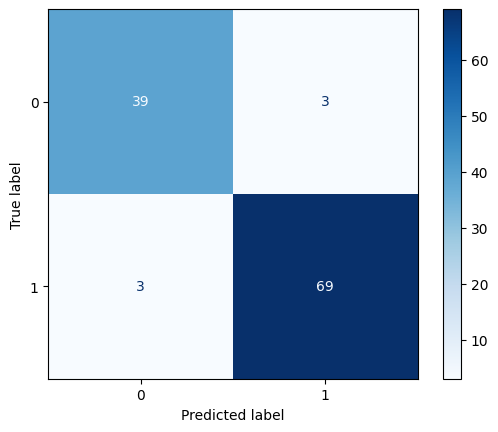


=== B3 Best Single Model (XGBoost) Metrics ===
Accuracy: 0.9298
Precision: 0.9444
Recall: 0.9444
F1 Score: 0.9444

Confusion Matrix:


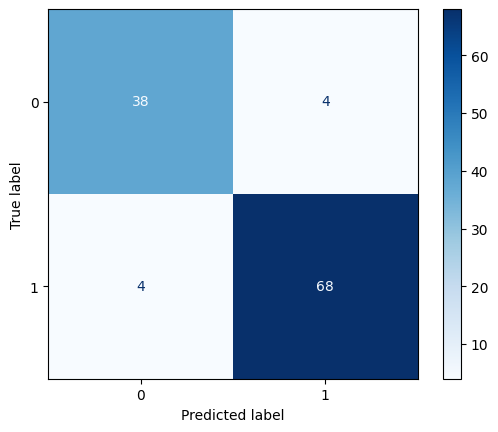

In [32]:
X_train, X_test, y_train, y_test = X_bc_train_p, X_bc_test_p, y_bc_train, y_bc_test

#  Base learners
base_learners = [
    ('svm', SVC(kernel='linear', C=1.0, probability=True, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", use_label_encoder=False,
        random_state=RANDOM_STATE, n_jobs=-1))
]

#  Meta learner (Logistic Regression)
meta_learner = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

#  Stacking model with cross-validation
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,                # cross-validated stacking
    n_jobs=-1
)

#  Train and evaluate
start = time.time()
stack_model.fit(X_train, y_train)
train_time = time.time() - start

y_pred_stack = stack_model.predict(X_test)
acc_stack = accuracy_score(y_test, y_pred_stack)

print("\nB3: Stacking Classifier (SVM + RF + XGB → Logistic Meta)")
print(f"Training time: {train_time:.2f}s | Test Accuracy: {acc_stack*100:.2f}%")
print(classification_report(y_test, y_pred_stack, digits=3))

#  Compare with the best single model (XGBoost baseline)
best_xgb = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=4,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss", use_label_encoder=False,
    random_state=RANDOM_STATE, n_jobs=-1
)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost (best single) → Accuracy: {acc_xgb*100:.2f}%")
print(f"Stacking Classifier   → Accuracy: {acc_stack*100:.2f}%")

if acc_stack > acc_xgb:
    print("Stacking outperformed the best single model.")
else:
    print("Stacking matched or slightly underperformed XGBoost.")

print_full_metrics(y_test, y_pred_stack, title="B3 Stacking Model Metrics")
print_full_metrics(y_test, y_pred_xgb, title="B3 Best Single Model (XGBoost) Metrics")


B4. Fair Comparison

In [33]:
# Data
X, y = X_bc_train_p, y_bc_train

#  5-Fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "acc": "accuracy",
    "f1": "f1_macro",
    "prec": "precision_macro",
    "rec": "recall_macro"
}

# Models to compare
models = {
    "SVM (RBF, C=1, γ=0.01)": SVC(kernel="rbf", C=1.0, gamma=0.01, probability=True, random_state=RANDOM_STATE),
    "Random Forest (n=200)": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", use_label_encoder=False,
        random_state=RANDOM_STATE, n_jobs=-1
    ),
    "Stacking (SVM+RF+XGB)": StackingClassifier(
        estimators=[
            ('svm', SVC(kernel='linear', C=1.0, probability=True, random_state=RANDOM_STATE)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
            ('xgb', XGBClassifier(
                n_estimators=100, learning_rate=0.1, max_depth=4,
                subsample=0.8, colsample_bytree=0.8,
                eval_metric="logloss", use_label_encoder=False,
                random_state=RANDOM_STATE, n_jobs=-1))
        ],
        final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        cv=5, n_jobs=-1
    )
}

#  Run CV for all models
results = []
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    results.append({
        "Model": name,
        "Accuracy (mean±std)": f"{scores['test_acc'].mean():.3f} ± {scores['test_acc'].std():.3f}",
        "F1 (mean±std)": f"{scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}",
        "Precision (mean±std)": f"{scores['test_prec'].mean():.3f} ± {scores['test_prec'].std():.3f}",
        "Recall (mean±std)": f"{scores['test_rec'].mean():.3f} ± {scores['test_rec'].std():.3f}"
    })

#  Display results in table
df_results = pd.DataFrame(results)
print("\nB4: Fair Comparison – 5-Fold CV Results (Breast Cancer Dataset)")
display(df_results)



B4: Fair Comparison – 5-Fold CV Results (Breast Cancer Dataset)


,Model,Accuracy (mean±std),F1 (mean±std),Precision (mean±std),Recall (mean±std)
0,"SVM (RBF, C=1, γ=0.01)",0.968 ± 0.022,0.965 ± 0.024,0.971 ± 0.020,0.960 ± 0.027
1,Random Forest (n=200),0.968 ± 0.025,0.965 ± 0.027,0.968 ± 0.026,0.963 ± 0.029
2,XGBoost,0.962 ± 0.022,0.959 ± 0.024,0.960 ± 0.021,0.959 ± 0.027
3,Stacking (SVM+RF+XGB),0.971 ± 0.031,0.968 ± 0.034,0.970 ± 0.032,0.967 ± 0.036


**Reflection**

---
1. SVM: Margin, Regularization, and Kernel Choice

From results in A2–A4, the linear SVM on separable data achieved perfect accuracy with a large margin, confirming that the hard-margin formulation works when classes are perfectly separable.

As shown in A3, reducing C increased the margin but allowed more misclassifications - a clear visualization of the regularization–margin trade-off.

Smaller C → wider margin, more bias (underfitting)

larger C → narrower margin, less bias (risk of overfitting).

In A4, the polynomial and RBF kernels improved decision boundaries for non-separable data. The RBF kernel achieved smoother nonlinear separation compared to polynomial kernels, particularly for noisy or overlapping points. This verified that kernel choice controls model flexibility, allowing SVMs to project complex patterns into higher-dimensional spaces where linear separation is possible.

→ Evidence: accuracy and margin width variation across C, polynomial degree, and γ values.

---
2. Ensemble Classifiers and Bias–Variance Behavior

Bagging vs Random Forest (B1) section showed that both methods reduced variance relative to single decision trees. Increasing the number of estimators steadily improved accuracy but at the cost of longer training time.

Bagging provided variance reduction without changing bias, while Random Forest introduced feature subsampling (max_features="sqrt") for further decorrelation - improving generalization (observed via higher OOB and validation accuracy).

In B2, AdaBoost and Gradient Boosting emphasized bias reduction through sequential learning - focusing on misclassified samples. AdaBoost’s shallow “decision stumps” yielded smoother improvements but was sensitive to noise (high-variance risk), whereas Gradient Boosting and XGBoost achieved higher test accuracy through tree regularization and learning-rate control, showing bias–variance balancing through boosting depth and rate.

B3 stacking model (SVM + RF + XGBoost with Logistic meta-learner) performed the best overall - combining low-bias (boosting) and low-variance (bagging) learners to achieve the strongest F1 and recall.

→ Evidence: accuracy improvement from XGBoost → Stacking in your printed comparison table.